__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [2]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/jupyter_0/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.0-CAPI-1.17.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [4]:
# !ls -1 data

## считываем данные

In [5]:
data_file = 'data/data_land.pkl'

In [6]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
# df['dt'] = pd.to_datetime( df['ts'].dt.date )
df['dt'] = df['ts'].dt.date
print(len(df))
df.sample(3)[cols]

15169


,title,adr,latitude,longitude,priceM,ts
12128,Участок 5 сот. (ИЖС),"Севастополь, улица Горпищенко, 151А",44.577214,33.583364,3.50,2022-11-04 17:12:55.140
14238,"Участок 8,5 сот. (ИЖС)","Севастополь,садоводческое товарищество Малыш",44.580732,33.474794,4.20,2022-11-15 13:16:46.237
946,"Участок 9,3 сот. (ИЖС)","Севастополь,ул. Бориса Шейнина, 60",44.58,33.55,5.80,2022-09-08 16:04:40.227


In [7]:
# df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None

In [8]:
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15169 entries, 0 to 15168
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               15169 non-null  object        
 1   price               15169 non-null  int64         
 2   obj_name            15169 non-null  object        
 3   adr_orig            15169 non-null  object        
 4   description         15169 non-null  object        
 5   avito_page          15169 non-null  int64         
 6   ts                  15169 non-null  datetime64[ns]
 7   place               15169 non-null  object        
 8   area                15169 non-null  float64       
 9   is_IJS              15169 non-null  bool          
 10  priceM              15169 non-null  float64       
 11  priceMU             15169 non-null  float64       
 12  area_size_category  15159 non-null  category      
 13  url                 15169 non-null  object    

In [10]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
11098,Участок 5 сот. (ИЖС),"Севастополь, Любимовка",44.66,33.54,2.20,2022-11-01 13:58:37.789
4369,"Участок 5,7 сот. (ИЖС)","Севастополь,дачный потребительский кооператив Горный, пер. Капитана Дьячкова",44.60463,33.579151,3.50,2022-09-15 10:31:26.039
11534,Участок 5 сот. (ИЖС),"Севастополь, Нахимовский район, Качинский район , городского типа Кача",44.772916,33.543659,2.90,2022-11-01 13:58:37.789


In [11]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

15169
15155


### ограничиваем тип объекта 

In [12]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [13]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
13774,Участок 5 сот. (ИЖС),"Севастополь,ул. Лётчика Старикова",44.672225,33.556469,2.10
6462,"Участок 1,33 га (ИЖС)","Севастополь,Комплексный памятник природы мыс Фиолент",44.50,33.49,77.00
13449,Участок 4 сот. (ИЖС),"Севастополь,жилищно-строительное товарищество индивидуальных застройщиков Сосновый Бор, Хвойный тупик",44.567306,33.482986,3.48


In [14]:
del df

In [15]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика

### количество предложений

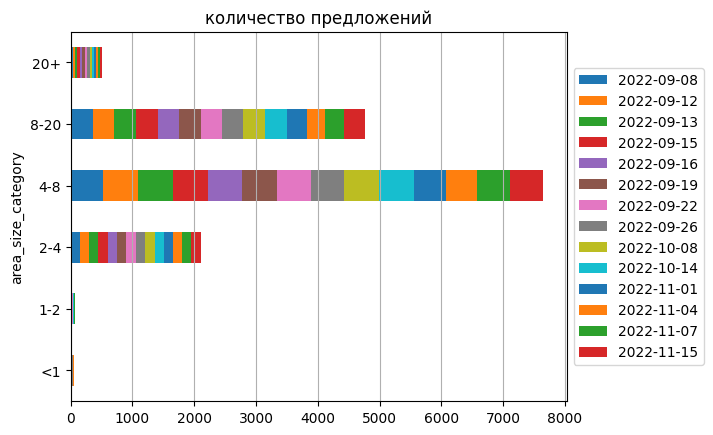

In [16]:
fig = ( # количество предложений
    gdf
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

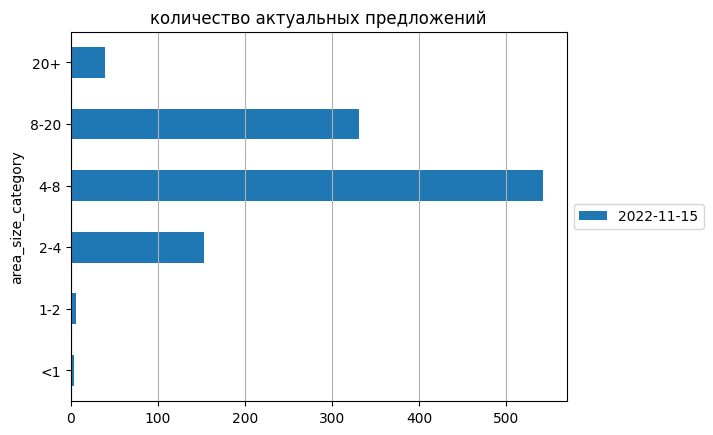

In [17]:
fig = ( # количество актуальных предложений
    gdf[ gdf['dt'] == gdf['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений', stacked=True )
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [18]:
stat = gdf.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])

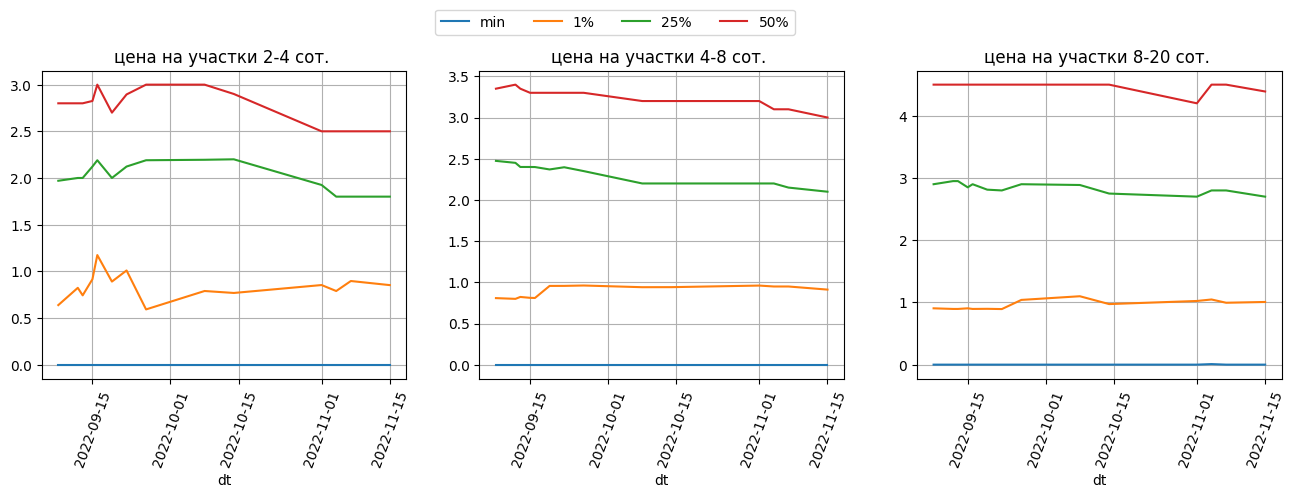

In [20]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i], legend=False,rot=70)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [21]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

In [22]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [23]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
23,862d28857ffffff,"POLYGON ((33.71787 44.53737, 33.69643 44.50794, 33.72323 44.47910, 33.77146 44.47968, 33.79291 44.50910, 33.76613 44.53794, 33.71787 44.53737))"
11,862d2d4a7ffffff,"POLYGON ((33.55110 44.76831, 33.52964 44.73892, 33.55659 44.71016, 33.60499 44.71079, 33.62646 44.74017, 33.59953 44.76893, 33.55110 44.76831))"


In [24]:
grid_values = ( 
    grid
    .sjoin( gdf[ gdf['dt']==gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [25]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [26]:
frames.explore('area_name')

In [27]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

15155
498


In [28]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[ gdf_['dt']==gdf_['dt'].max() ][cols].explore( 'area_size_category',legend=True)

### количество предложений

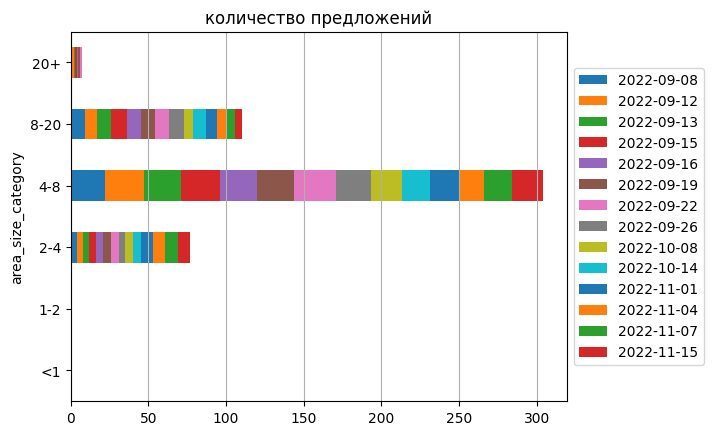

In [29]:
fig = ( # количество предложений
    gdf_
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh(legend=False,title='количество предложений',stacked=True)
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

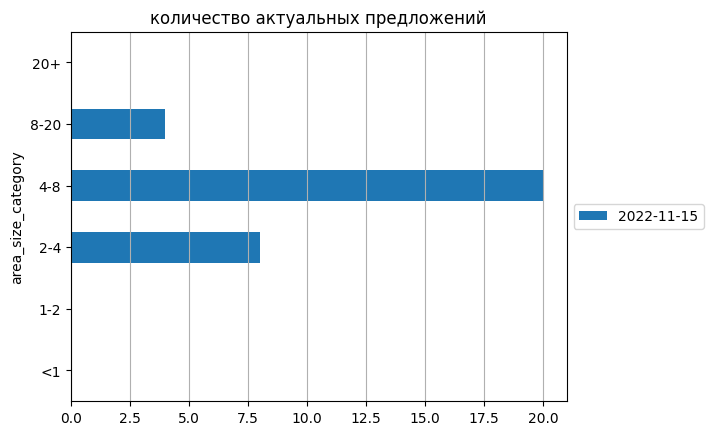

In [31]:
fig = ( # количество актуальных предложений
    gdf_[ gdf_['dt'] == gdf_['dt'].max() ]
    .groupby(['dt','area_size_category'])
    .size().reset_index()
    .pivot(index='area_size_category', columns='dt', values=0)
    .plot
    .barh( legend=False,title='количество актуальных предложений', stacked=True )
)
fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.grid(axis='x')

### изменение цены

In [32]:
stat = gdf_.groupby(['area_size_category','dt'])['priceM'].describe(percentiles=[.01,.1,.25,.5,.75,.9])

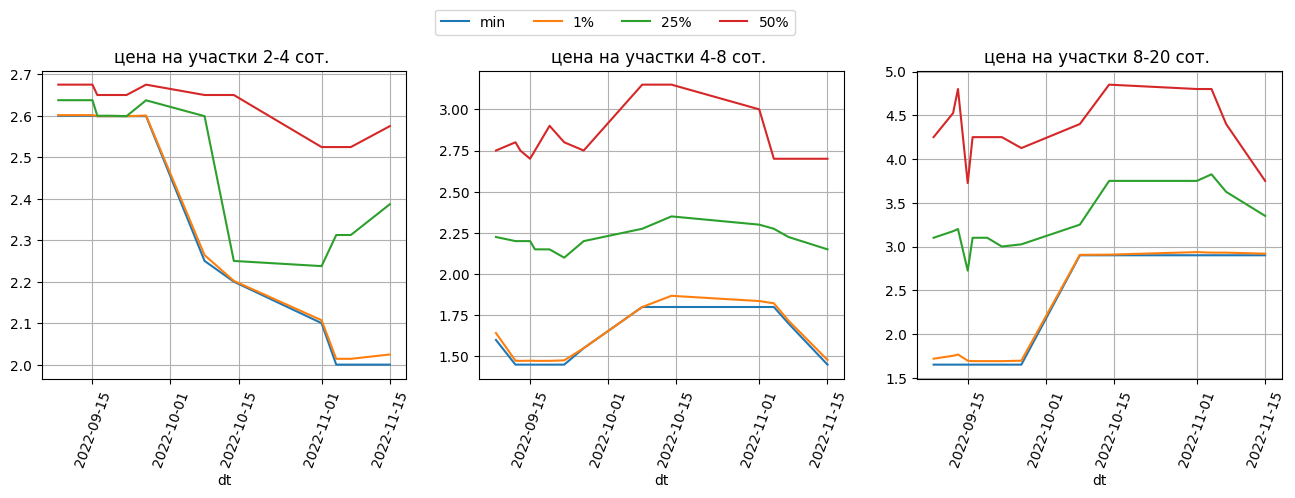

In [34]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
# sizes = [ '1-2', '2-4', '4-8', '8-20', ]
sizes = [ '2-4', '4-8', '8-20', ]
cols = ['min','1%','25%','50%']
# fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=True)
fig, ax = plt.subplots(1,len(sizes),figsize=(16,4), sharey=False)
for i,s in enumerate(sizes): 
    stat.loc[s,cols].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i], legend=False,rot=70)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 1.05))    

### гексагональная сетка и медиана актуальной цены

In [35]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
14,892d28943dbffff,"POLYGON ((33.53591 44.58382, 33.53558 44.58203, 33.53767 44.58087, 33.54008 44.58150, 33.54040 44.58329, 33.53832 44.58445, 33.53591 44.58382))"
8,892d28943d3ffff,"POLYGON ((33.53415 44.58677, 33.53382 44.58499, 33.53591 44.58382, 33.53832 44.58445, 33.53864 44.58624, 33.53656 44.58740, 33.53415 44.58677))"


In [36]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt'] == gdf['dt'].max() ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)